In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, silhouette_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

import re


import joblib

# Etape 1 : Exploration des données

In [2]:
# Chargement du fichier CSV contenant les avis sur les produits Nike

df = pd.read_csv('avis_nike.csv')
display(df.head())

print(df.shape)

,Review,Rating,Country,user_avis,Date
0,Pas de commande sans compteImpossible de passe...,1.0,FR,1avis,11 juillet 2024
1,Ne jamais commander sur NikeNe jamais commande...,1.0,FR,1avis,20 juin 2024
2,Jamais déçu du process de commandeJamais déçu ...,5.0,FR,2avis,24 octobre 2024
3,2 paires de TN full cuir défectueuse2 paires d...,1.0,BE,12avis,16 octobre 2024
4,N'achetez pas NikeLe service client que ce soi...,1.0,FR,6avis,01 août 2024


(831, 5)


In [18]:
# Types et statistiques descriptives des variables

display(df.info())

display(df.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831 entries, 0 to 830
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Review     813 non-null    object 
 1   Rating     816 non-null    float64
 2   Country    819 non-null    object 
 3   user_avis  820 non-null    object 
 4   Date       806 non-null    object 
dtypes: float64(1), object(4)
memory usage: 32.6+ KB


None

,Review,Rating,Country,user_avis,Date
count,813,816.000000,819,820,806
unique,793,NaN,22,41,640
top,Acheté une paire d'air max (authentique…Acheté...,NaN,FR,1avis,25 août 2023
freq,2,NaN,730,280,4
mean,NaN,2.042892,NaN,NaN,NaN
std,NaN,1.642794,NaN,NaN,NaN
min,NaN,1.000000,NaN,NaN,NaN
25%,NaN,1.000000,NaN,NaN,NaN
50%,NaN,1.000000,NaN,NaN,NaN
75%,NaN,4.000000,NaN,NaN,NaN


In [19]:
# Valeurs manquantes

df.isna().sum()

Review       18
Rating       15
Country      12
user_avis    11
Date         25
dtype: int64

In [25]:
# Suppression des valeurs manquantes

df = df.dropna()

In [21]:
# Duplicates

df.duplicated().sum()

19

In [26]:
# Suppression des duplicate

df = df.drop_duplicates()

In [27]:
# Supression de 'avis' dans la colonne user_avis et transformation en integer

df['user_avis'] = df['user_avis'].apply(lambda x : x[:-4]).astype(int)

In [29]:
# Création d'un dictionnaire associant le nom des mois en français à leur numéro correspondant au format 'MM'

mois_dict = {
    "janvier": '01',
    "février": '02',
    "mars": '03',
    "avril": '04',
    "mai": '05',
    "juin": '06',
    "juillet": '07',
    "août": '08',
    "septembre": '09',
    "octobre": '10',
    "novembre": '11',
    "décembre": '12'
}

In [30]:
# Création d'une variable mois à partir de la variable date

df['Month'] = df['Date'].apply(lambda x : x.split(' ')[1])
df['Month'] = df['Month'].replace(mois_dict)

In [31]:
# Mise en forme de la colonne 'Date' pour permettre sa conversion en format datetime

df['Date'] = df['Date'].apply(lambda x : x.split(' ')[0]) + '/' + df['Month'] + '/' + df['Date'].apply(lambda x : x.split(' ')[2])
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

In [32]:
# Visualisation des changements

display(df.head())
display(df.info())

,Review,Rating,Country,user_avis,Date,Month
0,Pas de commande sans compteImpossible de passe...,1.0,FR,1,2024-07-11,07
1,Ne jamais commander sur NikeNe jamais commande...,1.0,FR,1,2024-06-20,06
2,Jamais déçu du process de commandeJamais déçu ...,5.0,FR,2,2024-10-24,10
3,2 paires de TN full cuir défectueuse2 paires d...,1.0,BE,12,2024-10-16,10
4,N'achetez pas NikeLe service client que ce soi...,1.0,FR,6,2024-08-01,08


<class 'pandas.core.frame.DataFrame'>
Int64Index: 735 entries, 0 to 810
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Review     735 non-null    object        
 1   Rating     735 non-null    float64       
 2   Country    735 non-null    object        
 3   user_avis  735 non-null    int32         
 4   Date       735 non-null    datetime64[ns]
 5   Month      735 non-null    object        
dtypes: datetime64[ns](1), float64(1), int32(1), object(3)
memory usage: 37.3+ KB


None

# Etape 2 : Analyse des données avec la data visualisation

In [33]:
sns.set(style="whitegrid")

## A) Analyse univarié

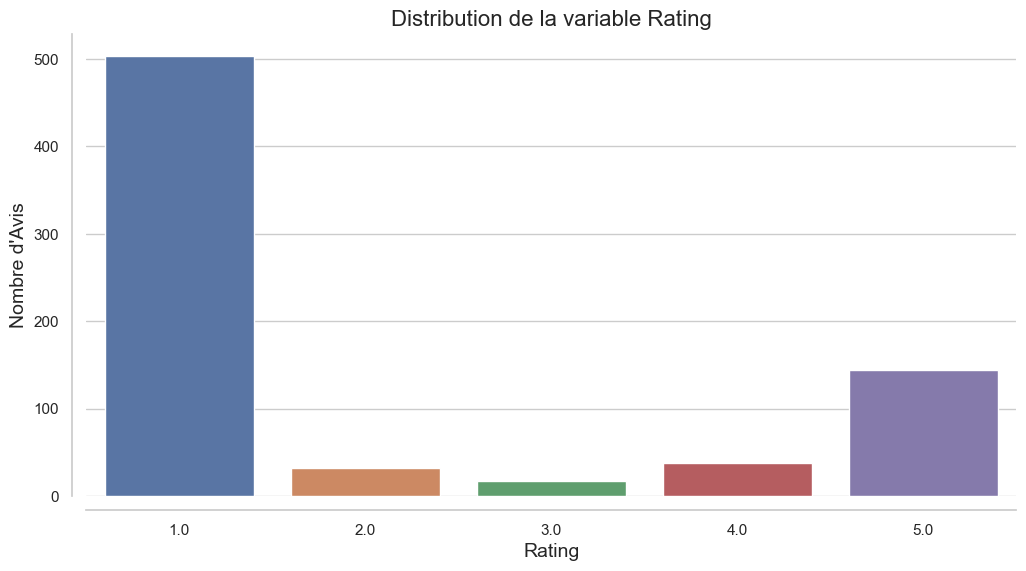

In [35]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Rating', data=df)

plt.title('Distribution de la variable Rating', fontsize=16)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Nombre d\'Avis', fontsize=14)
sns.despine(offset=10)

plt.show()

On a une majorité de mauvaises notes et surtout un manque énorme de notes intermédiaires. La variable cible est donc déséquilibrée. Cela sera à prendre en compte pour la Classification.

## B) Analyse temporelle

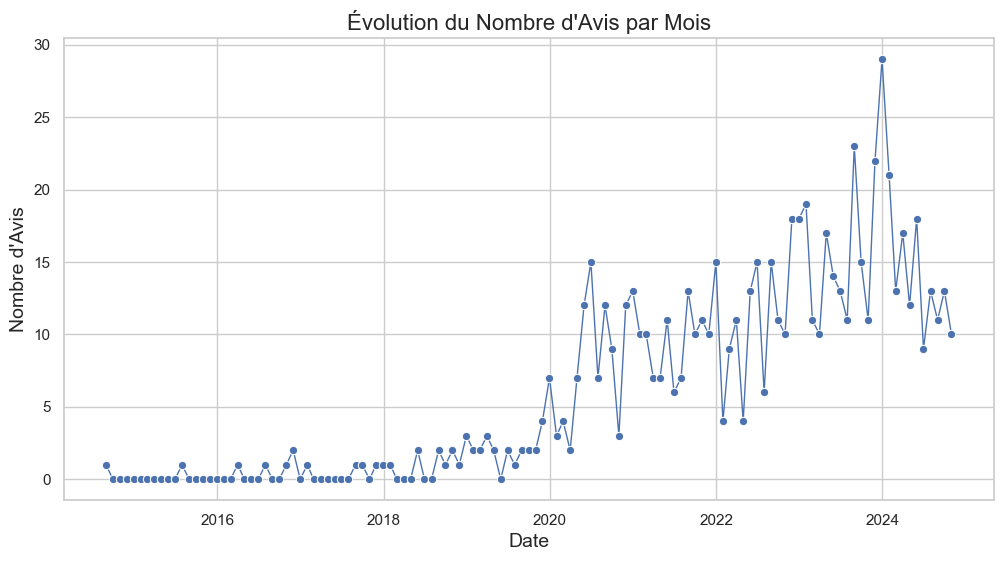

In [23]:
nb_avis_per_month = df.groupby(pd.Grouper(key='Date', freq='m'))['Rating'].count().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Rating', data=nb_avis_per_month, marker='o', linewidth=1)

plt.title("Évolution du Nombre d'Avis par Mois", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Nombre d'Avis", fontsize=14);

Ce graphique représente l'évolution du nombre d'avis par mois. On observe une forte augmentation du volume d'avis depuis 2018, avec des pics notables à partir de 2023. Cela pourrait indiquer une hausse de la participation des clients, potentiellement liée à des stratégies de sollicitation d'avis ou à des campagnes de marketing intensifiées par Nike.

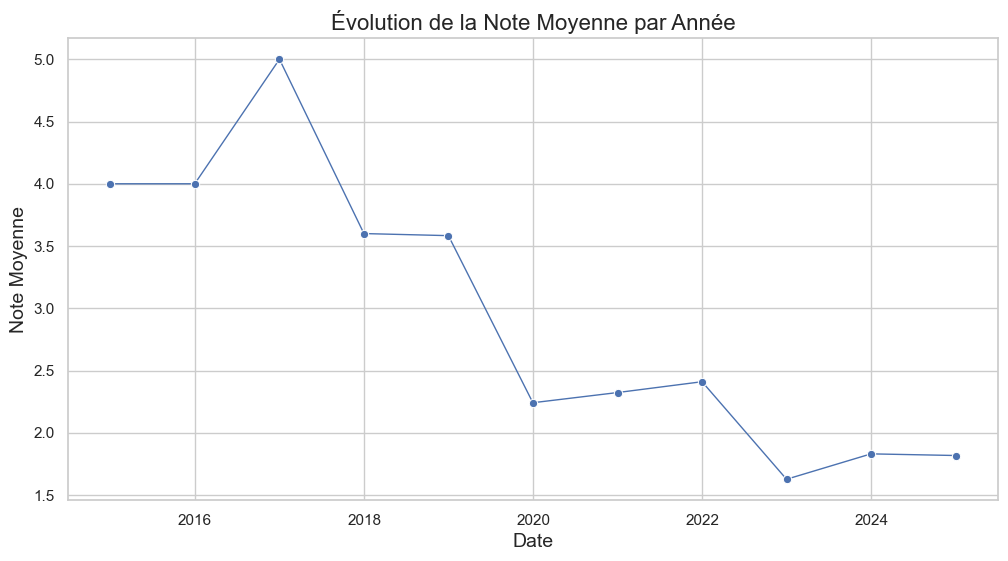

In [25]:
nb_avis_per_month = df.groupby(pd.Grouper(key='Date', freq='y'))['Rating'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Rating', data=nb_avis_per_month, marker='o', linewidth=1)

plt.title("Évolution de la Note Moyenne par Année", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Note Moyenne", fontsize=14);

Ce graphique montre une tendance à la baisse de la note moyenne sur les années. Cela pourrait indiquer une diminution progressive de la satisfaction des clients, ce qui pourrait être préoccupant pour Nike. Une baisse continue peut signaler des problèmes persistants ou de nouvelles insatisfactions liées aux produits ou aux services.

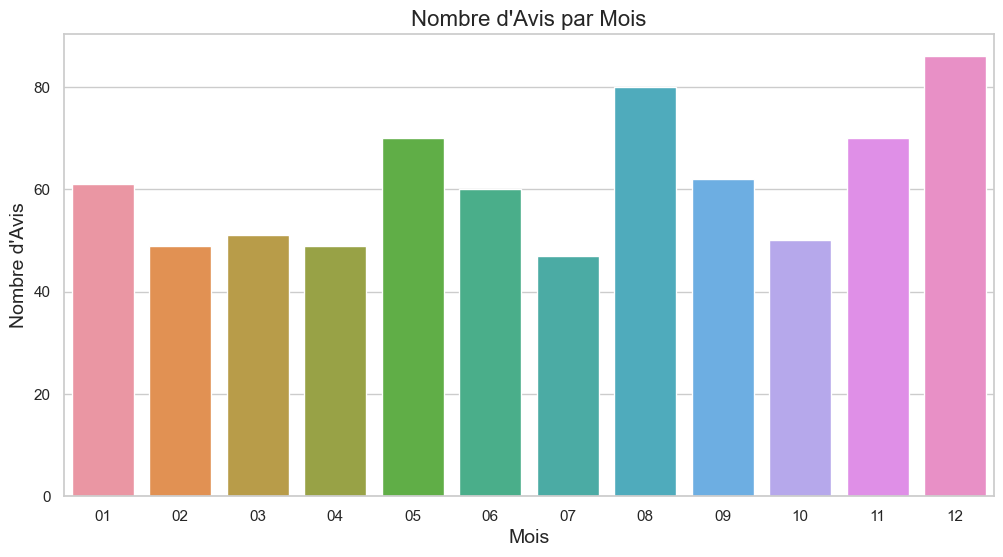

In [26]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Month', data=df.sort_values(by='Month'))

plt.title("Nombre d'Avis par Mois", fontsize=16)
plt.xlabel("Mois", fontsize=14)
plt.ylabel("Nombre d'Avis", fontsize=14);

Ce graphique indique des variations dans le volume d'avis selon les mois. Des pics durant certains mois (comme août et décembre) pourraient correspondre à des périodes de soldes ou de forte affluence. Cela peut être pertinent pour comprendre la saisonnalité de l'engagement client.

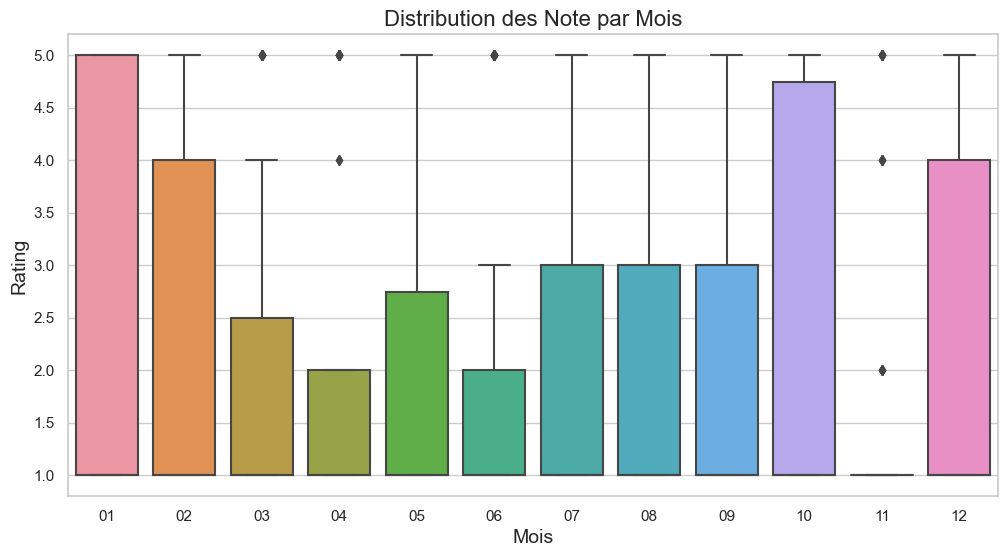

In [27]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Month', y='Rating', data=df.sort_values(by='Month'))

plt.title("Distribution des Note par Mois", fontsize=16)
plt.xlabel("Mois", fontsize=14)
plt.ylabel("Rating", fontsize=14);

On observe une variation de la distribution des notes par mois, avec des mois comme janvier et octobre montrant des notes plus élevées. Cela peut refléter des changements dans la qualité perçue ou des expériences spécifiques en fonction des saisons ou des collections de produits.

## C) Analyse des utilisateurs

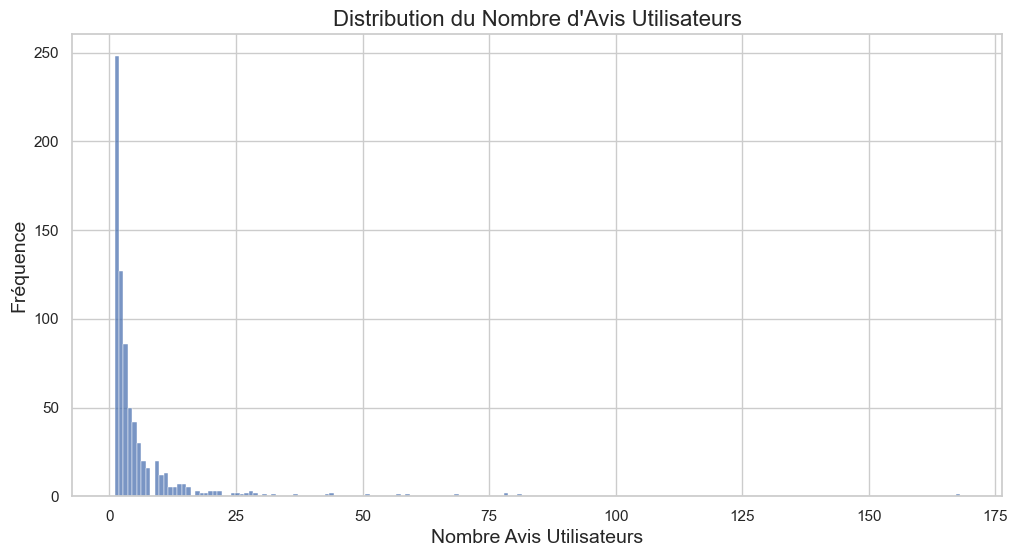

In [28]:
plt.figure(figsize=(12, 6))
sns.histplot(x='user_avis', data=df)

plt.title('Distribution du Nombre d\'Avis Utilisateurs', fontsize=16)
plt.xlabel('Nombre Avis Utilisateurs', fontsize=14) 
plt.ylabel('Fréquence', fontsize=14);

In [29]:
df['type_user'] = pd.cut(df['user_avis'], bins=[0, 1, 5, 10, max(df['user_avis'])], labels=['Once', 'rarely', 'few times', 'often'])

# Note moyenne par type d'utilisateur
df.groupby('type_user').agg(Rating_Mean=('Rating', 'mean'),
                            Rating_Count=('Rating', 'count'))

,Rating_Mean,Rating_Count
type_user,,
Once,1.717742,248
rarely,2.081967,305
few times,2.397959,98
often,2.369048,84


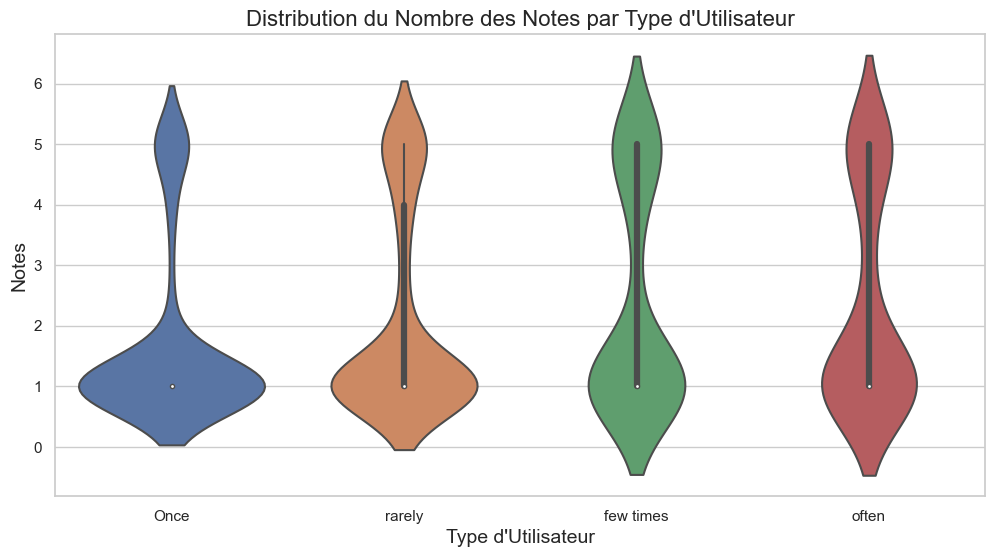

In [31]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='type_user', y='Rating', data=df)

plt.title('Distribution du Nombre des Notes par Type d\'Utilisateur', fontsize=16)
plt.xlabel('Type d\'Utilisateur', fontsize=14) 
plt.ylabel('Notes', fontsize=14);

Ce graphique en violon montre comment différents types de clients (occasionnels, rares, fréquents) évaluent leurs expériences. Les utilisateurs fréquents semblent donner des notes plus homogènes, tandis que les utilisateurs occasionnels ont une plus grande variabilité. Cela peut aider à identifier des segments de clients particulièrement critiques ou fidèles.

## D) Analyse des reviews

In [32]:
df['len_review'] = df['Review'].map(len)

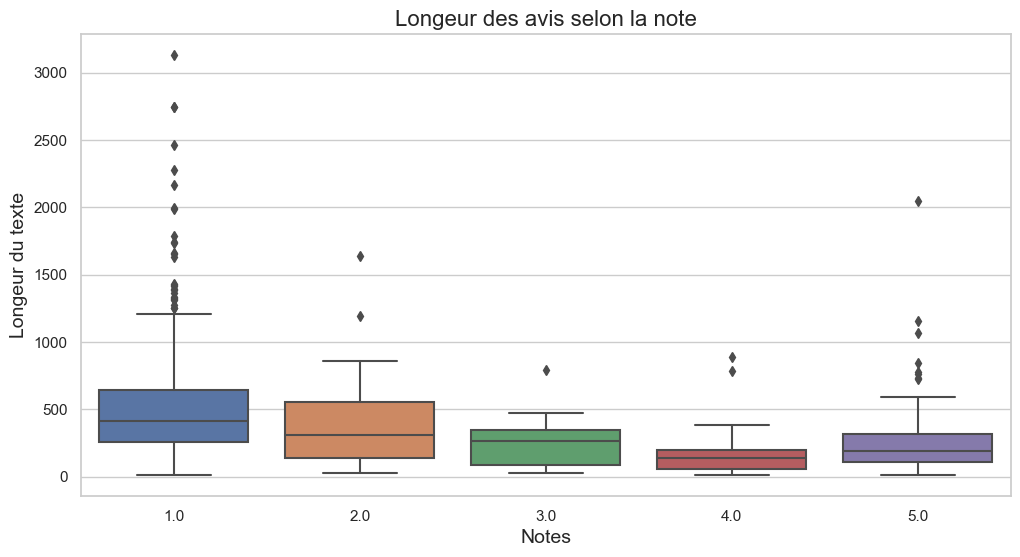

In [33]:
plt.figure(figsize=(12, 6))
sns.boxplot(y='len_review', x='Rating', data=df)

plt.title('Longeur des avis selon la note', fontsize=16)
plt.xlabel('Notes', fontsize=14) 
plt.ylabel('Longeur du texte', fontsize=14);

Ce graphique montre que les avis avec des notes faibles (1 et 2) tendent à être plus longs, ce qui est souvent le cas quand les clients insatisfaits expliquent leurs frustrations en détail. À l'inverse, les avis positifs (notes élevées) sont plus courts, souvent pour simplement exprimer leur satisfaction.

# Etape 3 : Preprocessing

In [37]:
# Conversion de tout le texte de la colonne 'Review' en minuscules pour uniformiser les données

df['Review'] = df['Review'].str.lower()

In [35]:
# Suppression de tous les chiffres dans la colonne 'Review' en utilisant une expression régulière

df['Review'] = df['Review'].apply(lambda x: re.sub(r'\d+', '', x))

In [39]:
# Tokenisation des avis dans la colonne 'Review' en utilisant la fonction word_tokenize

df['Review'] = df['Review'].map(word_tokenize)

In [41]:
# Suppression des stop words de chaque avis dans la colonne 'Review'

stop_words = set(stopwords.words('french'))
stop_words.update([',', '.', '!', '?', '...', '%', "’", '€', ':', 'nike', 'a', 'ai', 'ca'])

df['Review'] = df['Review'].apply(lambda x: [word for word in x if word not in stop_words])

In [42]:
# Lemmatisation des mots dans chaque avis de la colonne 'Review' pour réduire les mots à leur forme de base

lemmatizer = WordNetLemmatizer()
df['Review'] = df['Review'].apply(lambda x : [lemmatizer.lemmatize(word) for word in x])

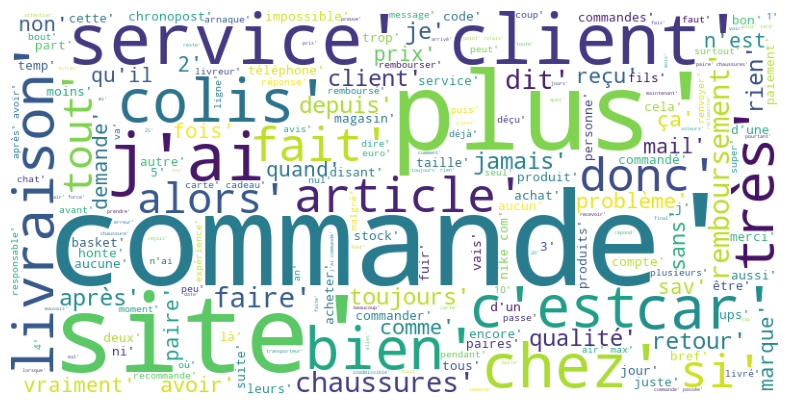

In [44]:
# Création d'un word cloud

text = ' '.join(df['Review'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Ce word cloud met en évidence les mots les plus fréquemment utilisés dans les avis clients. Les mots dominants comme "commande", "site", "service client", "colis", et "livraison" indiquent que beaucoup d'avis concernent des aspects logistiques et de service, ce qui pourrait indiquer des préoccupations liées aux commandes en ligne, aux retards de livraison, ou aux interactions avec le service client.

Les termes "problème", "remboursement", et "retour" suggèrent également des frustrations, probablement liées à des complications lors des retours de produits ou des demandes de remboursement. Les mentions de "chaussures" et "article" indiquent que les clients parlent souvent des produits spécifiques achetés.

L'utilisation de mots comme "jamais", "impossible", "trop", et "attente" dans le contexte de termes liés aux commandes et au service client peut refléter des sentiments d'insatisfaction ou des frustrations avec le processus de commande, les délais de livraison ou la résolution de problèmes.

Dans l'ensemble, ce word cloud souligne plusieurs domaines potentiels d'amélioration pour Nike, en particulier au niveau de la logistique et du service client. Une analyse approfondie de ces avis permettrait de mieux cibler les problématiques spécifiques et de mettre en place des actions pour améliorer l'expérience client.

# Etape 4 : Modélisation

## A) Clustering : Extraire les thèmes récurents

In [45]:
# Vectorisation des textes

df['Review'] = df['Review'].apply(lambda x: ' '.join(x))

tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X = tfidf_vectorizer.fit_transform(df['Review'])

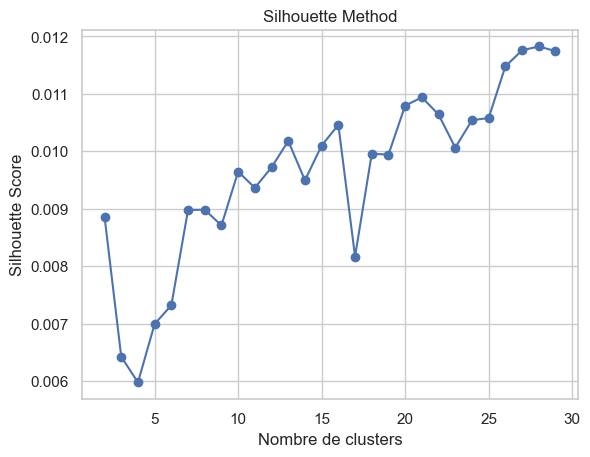

Nombre de clusters optimal basé sur le score de silhouette: 28


In [48]:
# Calcul du score de silhouette pour déterminer le nombre optimal de clusters

silhouette_scores = []
range_n_clusters = range(2, 30)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters = n_clusters, random_state=24)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Tracer le score de silhouette pour chaque nombre de clusters
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title("Silhouette Method")
plt.xlabel("Nombre de clusters")
plt.ylabel("Silhouette Score")
plt.show()

# Choisir le nombre optimal de clusters
optimal_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print(f"Nombre de clusters optimal basé sur le score de silhouette: {optimal_clusters}")

In [49]:
# Entraînement d'un modèle de clustering KMeans avec le nombre optimal de clusters

kmeans = KMeans(n_clusters=optimal_clusters, random_state=24)
df['Cluster'] = kmeans.fit_predict(X)

terms = tfidf_vectorizer.get_feature_names_out()
for i in range(optimal_clusters):
    print(f"\nCluster {i}:")
    cluster_center = kmeans.cluster_centers_[i]
    top_indices = cluster_center.argsort()[-15:]
    top_terms = [terms[idx] for idx in top_indices]
    print("Les mots les plus fréquents dans ce cluster:", top_terms, '\n')
    print("-"*100)


Cluster 0:
Les mots les plus fréquents dans ce cluster: ['chaussures', 'est', 'car', 'jamais', 'mois', 'en', 'étoile', 'mettre', 'si', 'plus', 'acheté', 'qualité', 'paire', 'chez', 'ça'] 

----------------------------------------------------------------------------------------------------

Cluster 1:
Les mots les plus fréquents dans ce cluster: ['colis', 'qualité', 'choix', 'si', 'retours', 'top', 'après', 'service', 'problème', 'très', 'site', 'recommande', 'livraison', 'rapide', 'produits'] 

----------------------------------------------------------------------------------------------------

Cluster 2:
Les mots les plus fréquents dans ce cluster: ['preuve', 'avoir', 'car', 'fois', 'vente', 'commande', 'depuis', 'remboursement', 'est', 'retour', 'ai', 'après', 'colis', 'client', 'service'] 

----------------------------------------------------------------------------------------------------

Cluster 3:
Les mots les plus fréquents dans ce cluster: ['grand', 'rapide', 'promos', 'jamai

In [50]:
# Affichage de la note moyenne par cluster

df.groupby('Cluster').agg(
    Rating_Mean=('Rating', 'mean'),
    Rating_Count=('Rating', 'count')
).sort_values(by='Rating_Mean', ascending=False)

,Rating_Mean,Rating_Count
Cluster,,
25,3.913043,23
12,3.750000,16
15,3.666667,15
21,3.454545,11
26,3.312500,16
1,3.307692,26
7,3.130435,23
3,3.000000,12
19,2.500000,22


## B) Classification : Prédire la satisfaction client

In [51]:
df['Rating'].value_counts()

# Remarque : il y a trop peu d'observations dans la classe intermédiaire des notes

1.0    503
5.0    145
4.0     38
2.0     32
3.0     17
Name: Rating, dtype: int64

In [52]:
# Regroupement des notes en deux groupes, les bonnes notes (1) et les mauvais notes (0)

y = df['Rating'].apply(lambda x : 1 if x >= 4 else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [54]:
y.value_counts()

0    552
1    183
Name: Rating, dtype: int64

In [87]:
# Entrainement d'un modèle XGBoost 
# xgb = XGBClassifier()
# xgb.fit(X_train, y_train)

xgb = joblib.load('xgb.joblib')

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       114
           1       0.63      0.58      0.60        33

    accuracy                           0.83       147
   macro avg       0.76      0.74      0.75       147
weighted avg       0.82      0.83      0.83       147



<Axes: >

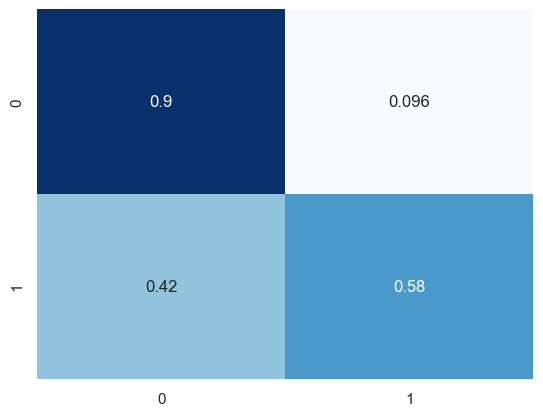

In [88]:
# Affichage des scores

y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred))

# Matrice de confusion

sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), cmap='Blues', annot=True, cbar=False)

In [89]:
# Rééquilibrage des classes dans les données d'entraînement en utilisant la technique SMOTE

smote = SMOTE(random_state=24)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [90]:
# On vérifie le rééquilibrage
y_train_resampled.value_counts()

Rating
0    438
1    438
Name: count, dtype: int64

In [91]:
# Entraînement du modèle avec les classes rééquilibrées
# xgb.fit(X_train_resampled, y_train_resampled)

xgb_ressampled = joblib.load('xgb_ressampled.joblib')

              precision    recall  f1-score   support

           0       0.92      0.87      0.89       114
           1       0.62      0.73      0.67        33

    accuracy                           0.84       147
   macro avg       0.77      0.80      0.78       147
weighted avg       0.85      0.84      0.84       147



<Axes: >

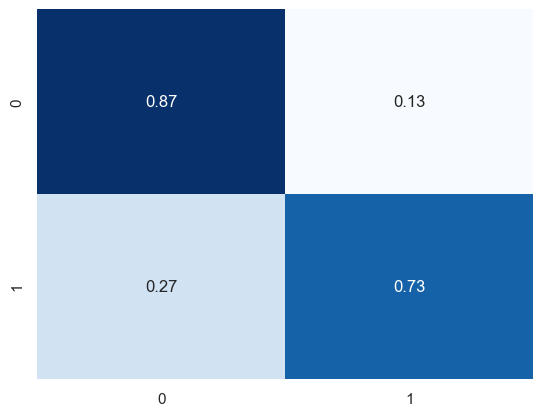

In [92]:
# Affichage des scores
y_pred = xgb_ressampled.predict(X_test)
print(classification_report(y_test, y_pred))

# Matrice de confusion
sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), cmap='Blues', annot=True, cbar=False)

In [93]:
# Réduction de la dimensionnalité en utilisant PCA tout en essayant de conserver entre 80 % et 90 % de la variance
pca = PCA(n_components=250)
X_train_pca = pca.fit_transform(X_train_resampled)
X_test_pca = pca.transform(X_test)

sum(pca.explained_variance_ratio_)

0.8427176617053024

In [94]:
# Entraînement du modèle après la réduction de dimension
# xgb.fit(X_train_pca, y_train_resampled)

xgb_pca = joblib.load('xgb_pca.joblib')

              precision    recall  f1-score   support

           0       0.94      0.89      0.92       114
           1       0.69      0.82      0.75        33

    accuracy                           0.88       147
   macro avg       0.82      0.86      0.83       147
weighted avg       0.89      0.88      0.88       147



<Axes: >

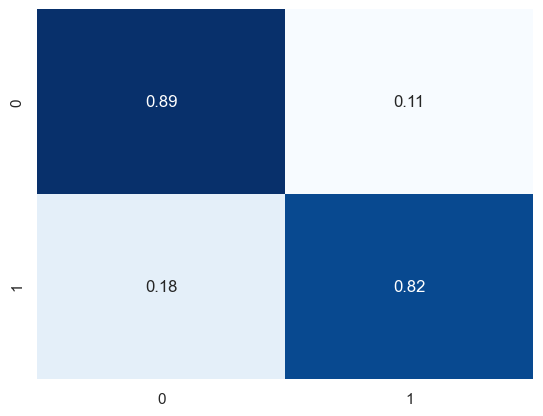

In [95]:
# Affichage des scores
y_pred = xgb_pca.predict(X_test_pca)
print(classification_report(y_test, y_pred))

# Matrice de confusion
sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), cmap='Blues', annot=True, cbar=False)

In [96]:
# Optimisation des hyperparamètres
"""param_grid = {
    'n_estimators': [380, 400, 410],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.09, 0.1, 0.11], 
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1
)

grid_search.fit(X_train_pca, y_train_resampled)

print("Meilleurs paramètres : ", grid_search.best_params_)

best_xgb = grid_search.best_estimator_"""

best_xgb = joblib.load('best_xgb.joblib')

              precision    recall  f1-score   support

           0       0.95      0.89      0.92       114
           1       0.70      0.85      0.77        33

    accuracy                           0.88       147
   macro avg       0.83      0.87      0.85       147
weighted avg       0.90      0.88      0.89       147



<Axes: >

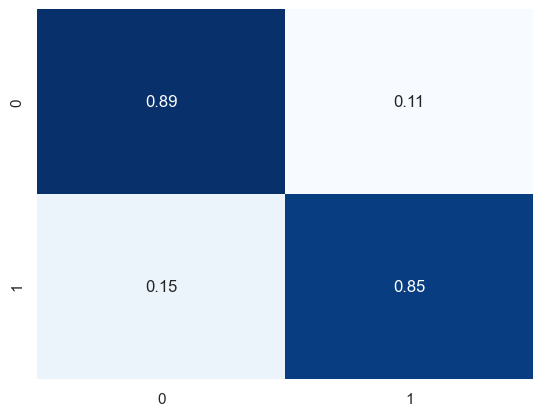

In [97]:
# Affichage des scores
y_pred = best_xgb.predict(X_test_pca)
print(classification_report(y_test, y_pred))

# Matrice de confusion
sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), cmap='Blues', annot=True, cbar=False)

# Etape 5 : Interprétabilité

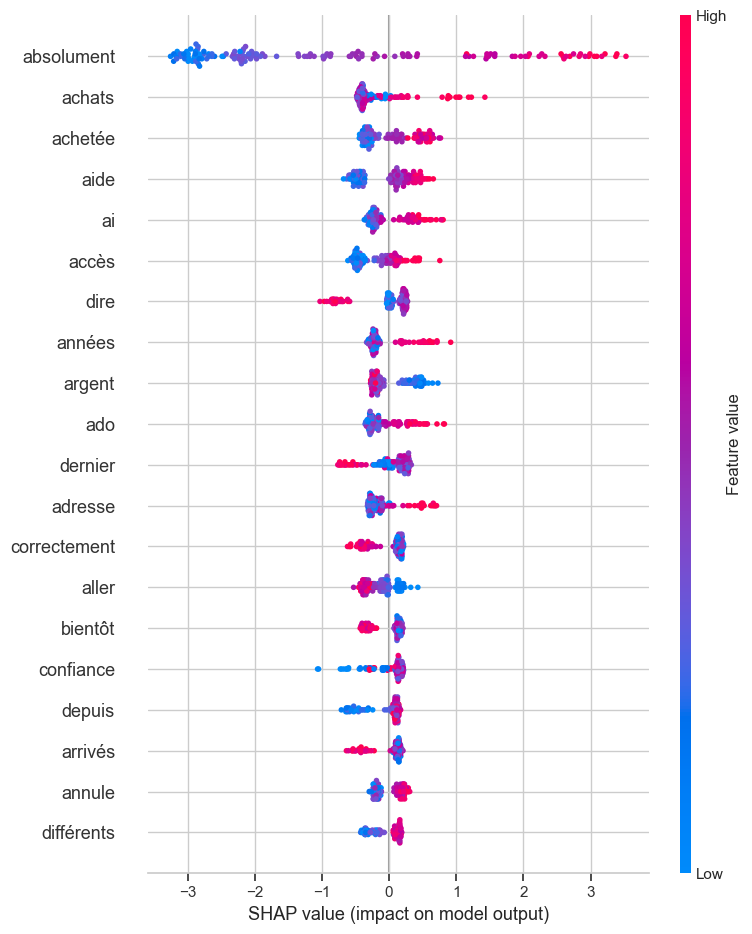

In [98]:
# Calcule des valeurs de shapley

import shap

explainer = shap.TreeExplainer(best_xgb) 
shap_values = explainer.shap_values(X_test_pca)

# Affichage du summary plot

shap.summary_plot(shap_values, X_test_pca, feature_names = terms)